## Tutorial mdfeature 


Author: Zofia Trstanova   
Edits: Dom Phillips

In [2]:
%matplotlib inline
#import metadynamics
from openmm import *
from openmm.app import *
from openmm.unit import *
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as image
from pyemma import msm
from scipy.interpolate import griddata
from matplotlib.pyplot import cm
import mdtraj as md
from ipywidgets import IntProgress
from IPython.display import display
import time
import numpy as np

import mdfeature.features as features

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 2
font = {'family' : 'sans-serif',
        'size'   : 14.0}
mpl.rc('font', **font) 

mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] =  16
mpl.rcParams['font.size'] =  15
mpl.rcParams['figure.autolayout'] =  True
mpl.rcParams['figure.figsize'] =  7.2,4.45
mpl.rcParams['axes.titlesize'] =  16
mpl.rcParams['axes.labelsize'] =  17
mpl.rcParams['lines.linewidth'] =  2
mpl.rcParams['lines.markersize'] =  6
mpl.rcParams['legend.fontsize'] =  13


## Initiating OpenMM to run or load a short trajectory

In [4]:
# Bunch of useful simulation parameters
steps = 100
iterations = 10000
temperature = 300
beta = 1.0/(temperature*0.0083144621)

Run a Langevin dynamics simulation using the Amber forcefield at $300K$ with friction coefficient of 1 $ps^{-1}$ and stepsize $0.002 ps$.

In [5]:
pdb_name = 'alanine.pdb'
pdb = PDBFile(pdb_name)
saving_file = 'trajectory.dcd'

forcefield = ForceField('amber14-all.xml', 'amber14/spce.xml')
system = forcefield.createSystem(pdb.topology, nonbondedMethod=CutoffNonPeriodic, constraints=HBonds)

integrator = LangevinIntegrator(temperature*kelvin, 1.0/picosecond, 0.002*picoseconds)
simulation = Simulation(pdb.topology, system, integrator, platform=Platform.getPlatformByName('CPU'))
simulation.context.setPositions(pdb.positions)
simulation.context.setVelocitiesToTemperature(temperature*kelvin)



Features module contains functions to print the name of the torsions.

In [6]:
# check the loaded topology

print(pdb.topology)
topology = md.load(pdb_name).topology
print(topology)

table, bonds = topology.to_dataframe()
#print(table)

<Topology; 1 chains, 3 residues, 22 atoms, 21 bonds>
<mdtraj.Topology with 1 chains, 3 residues, 22 atoms, 33 bonds>


Displays designation name of torsion angle for given atom indices (phi, psi)

In [7]:
import mdfeature.features as features

phi = [4, 6, 8 ,14] #dihedral coordinates # [4, 6, 8 ,14]#[1, 6, 8, 14]
psi = [6, 8, 14, 16]

phi_name = features.get_name_torsion(phi, pdb_file=pdb_name, table=table)
psi_name = features.get_name_torsion(psi, pdb_file=pdb_name, table=table)

print('Long name')
print(phi_name)
print(psi_name)

phi_name_short = features.get_name_torsion(phi, pdb_file=pdb_name, table=table, format='short')
psi_name_short = features.get_name_torsion(psi, pdb_file=pdb_name, table=table, format='short')

print('Short name')
print(phi_name_short)
print(psi_name_short)

Long name
ACE1C-ALA2N-ALA2C-ALA2C
ALA2N-ALA2C-ALA2C-NME3N
Short name
1C-2N-2C-2C
2N-2C-2C-3N


In [8]:
# Run the simulation

# if False, dont run
run = False

mdinit = md.load_pdb(pdb_name)
    
if run: 

    mdinit.save_dcd(saving_file)     
    simulation.reporters.append(DCDReporter(saving_file, steps, append=True))

    max_count = iterations
    bar = IntProgress(min=0, max=max_count) # instantiate the bar
    display(bar) # display the bar
    
    for i in range(iterations):
        
        bar.value += 1
        simulation.step(steps)

        state = simulation.context.getState(getEnergy=True, enforcePeriodicBox = False)
        positions = simulation.context.getState(getPositions=True).getPositions()
        


## Load trajectory

In [14]:
traj_std_tmp = md.load_dcd('test_traj.dcd', mdinit.topology)

skip_first = 1000
traj_orig = traj_std_tmp[skip_first:]
print(traj_orig)
traj_orig = traj_orig.superpose(traj_orig[0])

<mdtraj.Trajectory with 9001 frames, 22 atoms, 3 residues, without unitcells>


### Compute diffusionmap

Module diffusionmap allows to compute the diffusion maps from the trajectory.

We first show how to compute the vanilla diffusionmap

In [10]:
import mdfeature.diffusionmap as diffusionmap

mydmap, traj = diffusionmap.compute_diffusionmaps(traj_orig, nrpoints=2000, epsilon=1.0)

<mdtraj.Trajectory with 9001 frames, 22 atoms, 3 residues, without unitcells>
Subsampled to
<mdtraj.Trajectory with 2000 frames, 22 atoms, 3 residues, without unitcells>
Computing vanilla diffusionmap


In [11]:
evec = np.asarray(mydmap.evecs[:,0])
print(evec[1:].shape)
print(len(traj))

(1999,)
2000


Compute time evolution of torsion angle for defined atomic indices. Plot them as a function of the diffusion coordinate(s).

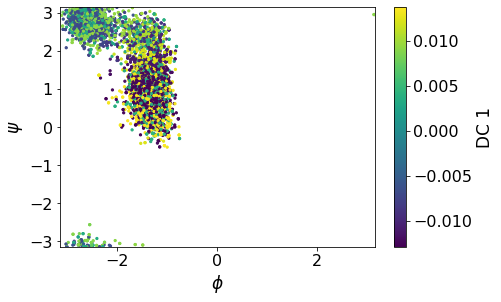

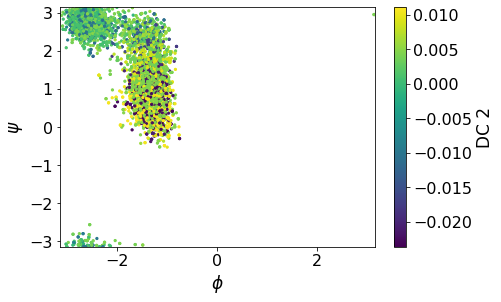

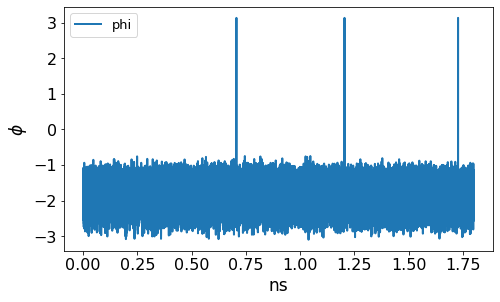

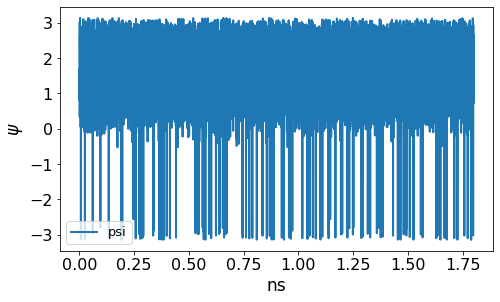

In [50]:
phi_torsion = features.compute_torsion_mdraj(traj, phi)
psi_torsion = features.compute_torsion_mdraj(traj, psi)

clb = plt.scatter(phi_torsion, psi_torsion, c=mydmap.evecs[:,0], s=5)
plt.colorbar(clb, label='DC 1')
plt.xlim([-np.pi, np.pi])
plt.ylim([-np.pi, np.pi])

plt.xlabel(r'$\phi$')
plt.ylabel(r'$\psi$')
plt.show()


clb = plt.scatter(phi_torsion, psi_torsion, c=mydmap.evecs[:,1], s=5)
plt.colorbar(clb, label='DC 2')
plt.xlim([-np.pi, np.pi])
plt.ylim([-np.pi, np.pi])

plt.xlabel(r'$\phi$')
plt.ylabel(r'$\psi$')
plt.show()

time = np.arange(0, 9000*steps*0.002*0.001, 9000*steps*0.002*0.001/9000)
plt.plot(time, phi_torsion, label='phi')
plt.xlabel('ns')
plt.ylabel(r'$\phi$')
plt.legend()
plt.show()
plt.plot(time, psi_torsion, label='psi')
plt.xlabel('ns')
plt.ylabel(r'$\psi$')
plt.legend()
plt.show()

### TMDmap

The TMDmap (target measure diffusion map) allows for Boltzmann correction exp(-beta*V(x)).

<mdtraj.Trajectory with 9001 frames, 22 atoms, 3 residues, without unitcells>
Subsampled to
<mdtraj.Trajectory with 2000 frames, 22 atoms, 3 residues, without unitcells>
Energy has shape
(2000,)
Computing TMDmap with target measure exp(-beta(V(x)))


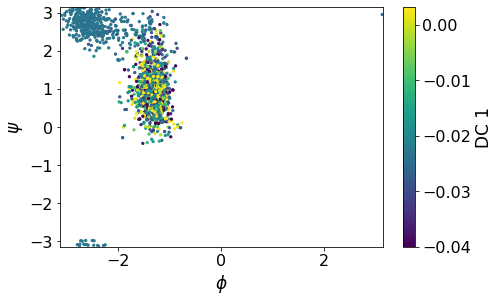

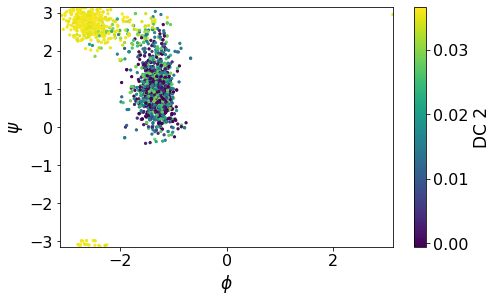

In [12]:
import mdfeature.diffusionmap as diffusionmap

weight_params = {}
weight_params['simulation'] = simulation
weight_params['temperature'] = 300

mydmap_tmd, traj = diffusionmap.compute_diffusionmaps(traj_orig, nrpoints=2000, epsilon=1.0, weights='compute', weight_params=weight_params)

#######################################################
phi_torsion = features.compute_torsion_mdraj(traj, phi)
psi_torsion = features.compute_torsion_mdraj(traj, psi)

clb = plt.scatter(phi_torsion, psi_torsion, c=mydmap_tmd.evecs[:,0], s=5)
plt.colorbar(clb, label='DC 1')
plt.xlim([-np.pi, np.pi])
plt.ylim([-np.pi, np.pi])

plt.xlabel(r'$\phi$')
plt.ylabel(r'$\psi$')
plt.show()


clb = plt.scatter(phi_torsion, psi_torsion, c=mydmap_tmd.evecs[:,1], s=5)
plt.colorbar(clb, label='DC 2')
plt.xlim([-np.pi, np.pi])
plt.ylim([-np.pi, np.pi])

plt.xlabel(r'$\phi$')
plt.ylabel(r'$\psi$')
plt.show()

### Explicit weights
It is possible to compute diffusionmaps with explicit weights.

Energy has shape
(2000,)
<mdtraj.Trajectory with 9001 frames, 22 atoms, 3 residues, without unitcells>
Subsampled to
<mdtraj.Trajectory with 2000 frames, 22 atoms, 3 residues, without unitcells>
Computing TMDmap with explicit weights


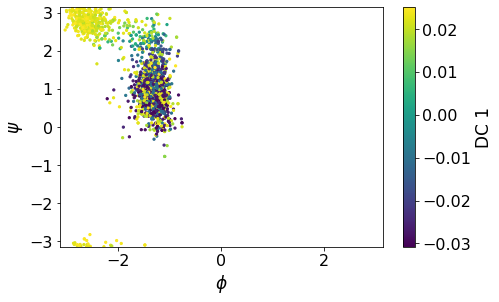

In [13]:
from openmmtools.constants import kB

simulation = weight_params['simulation']

positions = simulation.context.getState(getPositions=True).getPositions()
energy_unit = diffusionmap.energy(positions, simulation).unit
positions_unit = positions.unit

E = diffusionmap.compute_energy(traj.xyz, simulation, positions_unit, energy_unit)
print('Energy has shape')
print(E.shape)

# example: renormalize to new temperature value
T_orig = 300
kT_orig = kB * T_orig * kelvin

T2 = 400
kT2 = kB * T2 * kelvin

density_T_orig = diffusionmap.compute_target_measure(E, kT_orig, energy_unit)
density_T2 = diffusionmap.compute_target_measure(E, kT2, energy_unit)
        
weights = density_T2 / density_T_orig

weight_params = {}
weight_params['simulation'] = simulation
weight_params['weights'] = weights

mydmap_expl, traj = diffusionmap.compute_diffusionmaps(traj_orig, nrpoints=2000, epsilon=1.0, weights='explicit', weight_params=weight_params)


#######################################################
phi_torsion = features.compute_torsion_mdraj(traj, phi)
psi_torsion = features.compute_torsion_mdraj(traj, psi)

clb = plt.scatter(phi_torsion, psi_torsion, c=mydmap_expl.evecs[:,0], s=5)
plt.colorbar(clb, label='DC 1')
plt.xlim([-np.pi, np.pi])
plt.ylim([-np.pi, np.pi])

plt.xlabel(r'$\phi$')
plt.ylabel(r'$\psi$')
plt.show()



We continue using the vanilla diffusionmap for the rest of the tutorial.

In [32]:
import mdfeature.diffusionmap as diffusionmap

mydmap, traj = diffusionmap.compute_diffusionmaps(traj_orig, nrpoints=9000, epsilon=1.0)

<mdtraj.Trajectory with 9001 frames, 22 atoms, 3 residues, without unitcells>
Subsampled to
<mdtraj.Trajectory with 9000 frames, 22 atoms, 3 residues, without unitcells>
Computing vanilla diffusionmap


computing free energy contour of the diffusion map space

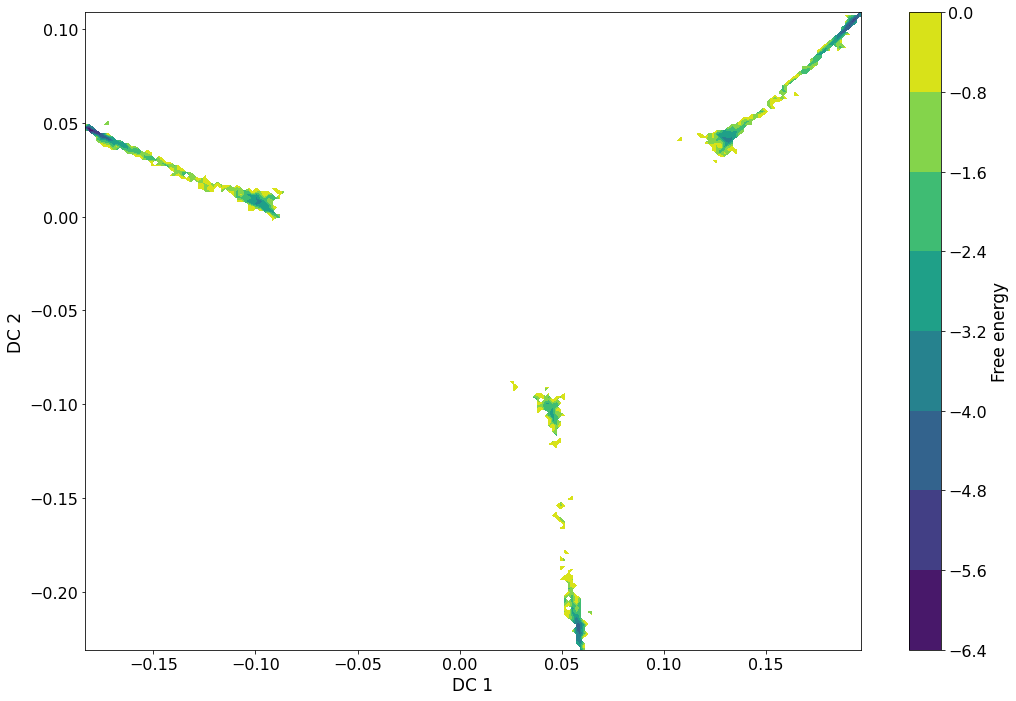

In [37]:
free_energy_dc, edx, edy = np.histogram2d(mydmap.dmap[:,0], mydmap.dmap[:,1], bins=200)
#print(free_energy_dc)
#print(edx)
#print(edy)
with numpy.errstate(divide='ignore'):
    free_energy_dc = -np.log(free_energy_dc)

fig = plt.figure(figsize=(15,10))
clb = plt.contourf(edx[1:], edy[1:], free_energy_dc.T)
#plt.contourf([edx, edy,], free_energy_dc.T)
plt.colorbar(clb, label='Free energy')

plt.xlabel('DC 1')
plt.ylabel('DC 2')

plt.show()

Module features contains also functions to define list of features, compute all the correlations with the diffusion coordinates and select the best ones.

In [39]:
phi = [4, 6, 8 ,14] #dihedral coordinates
psi = [6, 8, 14, 16]
zeta = [1, 4, 6, 8]
theta = [8, 14, 16, 18]

default_torsions = [phi, psi, zeta, theta]
all_combinations = features.create_torsions_list(atoms=traj.xyz.shape[1], size=100, append_to=default_torsions, print_list=False)

In [40]:
dimension = 2

list_of_functions =['compute_cos_torsion_mdraj' for _ in range(len(all_combinations))]
#print(traj)
#print(mydmap)
#print(list_of_functions)
#print(all_combinations)
correlations = features.compute_all_correlations(traj, mydmap, dimension, list_of_functions, nevery=10, list_of_params=all_combinations)
#TODO fix bug in correlation code

Dimension 1


IntProgress(value=0, max=104)

/home/dominic/PycharmProjects/mdfeature/src/mdfeature/features.py:99: RuntimeWarning: invalid value encountered in arccos
  theta = np.arccos(cos_theta) * np.sign(np.dot(rkj, np.cross(t, u)))


Dimension 2


IntProgress(value=0, max=104)

In [41]:
# choose the two best ones
cv_indices, correlations_cv, cv_indices_2, correlations_cv_2 = features.identify_features(correlations, all_combinations, dimension)



Number of cvs:
104
Maximal cv:
index:
[ 6  9 10 13]
corr:
0.9710569649777167
Second naximal cv:
index:
[ 4 11 13 15]
corr:
-0.8620987510843332
Number of cvs:
104
Maximal cv:
index:
[ 1  8 11 14]
corr:
-0.7682759087703386
Second naximal cv:
index:
[ 4  9 12 13]
corr:
-0.5439848200632056


In [42]:
print(cv_indices)
print(correlations_cv)

[array([ 6,  9, 10, 13]), array([ 1,  8, 11, 14])]
[0.9710569649777167, -0.7682759087703386]


In [43]:
cv_indices_minimal, correlations_cv_minimal = features.identify_worst_features(correlations, all_combinations, dimension)


(104, 2)
[]
[79]
[21 73 79 93]


\Minimal correlated collective variables:
[array([ 3,  5,  8, 20]), array([ 1,  8, 10, 17])]
[1, 8, 10, 17]
Corr:
[[-1.89986237e-02 -3.14517390e-03]
 [-1.97103119e-02  1.12749694e-03]
 [ 3.30750987e-03 -6.45941280e-05]
 [ 5.35274802e-03 -1.55253959e-02]]


In [44]:
torsion_max = features.compute_torsion_mdraj(traj, cv_indices[0])
torsion_max_1 = features.compute_torsion_mdraj(traj, cv_indices[1])

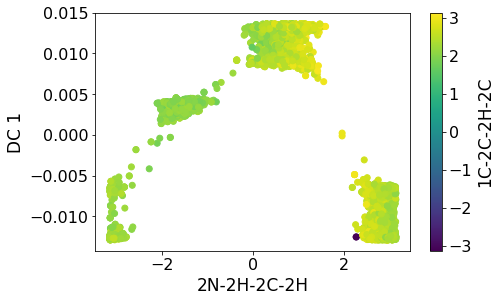

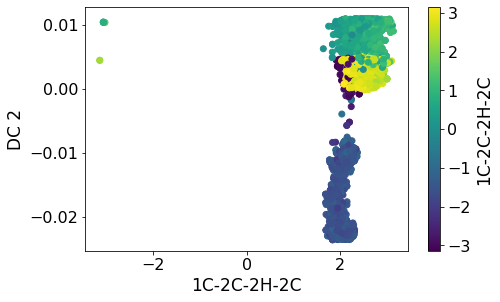

In [45]:
clb = plt.scatter(torsion_max, mydmap.evecs[:,0], c=torsion_max_1)
plt.colorbar(clb, label=(features.get_name_torsion(cv_indices[1], pdb_file=pdb_name, table=table, format='short')))
plt.xlabel(features.get_name_torsion(cv_indices[0], pdb_file=pdb_name, table=table, format='short'))
    
plt.ylabel('DC 1')
plt.show()

clb = plt.scatter(torsion_max_1, mydmap.evecs[:,1], c=torsion_max)
plt.colorbar(clb, label=(features.get_name_torsion(cv_indices[1], pdb_file=pdb_name, table=table, format='short')))
plt.xlabel((features.get_name_torsion(cv_indices[1], pdb_file=pdb_name, table=table, format='short')))
plt.ylabel('DC 2')
plt.show()
#TODO: fix plot